In [1]:
# install these libraries if you don't already have them
# !pip install facebook_scraper
# !pip install vaderSentiment
# !pip install openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from collections.abc import Iterable
from facebook_scraper import get_posts 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import spacy
from spacy.matcher import PhraseMatcher
import statsmodels.api as sm

In [2]:
listposts = []

for post in get_posts('primelands', cookies="/Users/kelumrubasin/Desktop/MSC_DATA_SCIENCE/1_Social_Media_Analytics/Assignment_CIS7029/facebook_data/facebook.com_cookies.txt",
                      pages=50,
                      options={'comments': True}):
    listposts.append(post)
    
print('Number of posts: {}'.format(len(listposts)))   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/facebook_scraper/facebook_scraper.py:881: UserWarning: Facebook says 'Unsupported Browser'
  warnings.warn(f"Facebook says 'Unsupported Browser'")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/dateparser/freshness_date_parser.py:76: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  now = self.get_local_tz().localize(now)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en

Number of posts: 198


In [3]:
columns = ['post_id', 
           'time',  
           'text', 
           'likes',
           'comments', 
           'shares', 
           'comments_full']

df_posts = pd.DataFrame(listposts)[columns]

In [4]:
df_posts['text'].replace('', np.nan, inplace=True)
df_posts.dropna(subset=['text'], inplace=True)
df_posts

,post_id,time,text,likes,comments,shares,comments_full
0,10160184885147290,2022-07-22 13:36:16,අනුරාධපුර - පුත්තලම පාරට මුහුණලා අගනා නේවාසික ...,191,1,1,[]
1,10160184882127290,2022-07-22 13:33:03,සුන්දර වෙල්යායකට මුහුණලා අනුරාධපුරෙන් අගනා බිම...,139,4,0,"[{'comment_id': '1025783138104225', 'comment_u..."
2,10160184880962290,2022-07-22 13:31:30,දඹුල්ල මහ නගරසභා සීමාවෙන් වටිනා බිම් කොටස්\n👉 ...,87,3,3,"[{'comment_id': '1891518234391123', 'comment_u..."
3,10160184877312290,2022-07-22 13:27:39,මුලු ඉඩමම ලක්ෂ 15කට නාරම්මල හොඳම තැනකින්!!!\n📲...,39,2,0,"[{'comment_id': '1389563371566531', 'comment_u..."
4,10160183726687290,2022-07-21 19:49:52,අහංගම - ඉමදූව බස් පාරට මුහුණලා අගනා බිම් කොටස්...,198,3,11,"[{'comment_id': '379629477616441', 'comment_ur..."
...,...,...,...,...,...,...,...
193,10160045127092290,2022-05-06 14:29:05,Are You Planning to Buy a Land?\n👉 We Love to ...,5200,28,12,[]
194,10160043495567290,2022-05-05 18:38:16,"""සිහින දකින්න ඕනේ, දැකලා විතරක් මදි, ඒවා සැබෑ ...",194,8,58,[]
195,10160043475707290,2022-05-05 18:11:45,Prime Group crowned ‘Most Valuable Real Estate...,3300,15,30,[]
196,10160041694222290,2022-05-04 20:03:50,කළුතර හැම දේටම ලඟ හොඳම තැනකින් සුපිරි බිම් කොට...,919,29,11,[]


In [52]:
from langdetect import detect

def detect_en(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df_posts = df_posts[df_posts['text'].apply(detect_en)]
df_posts

,post_id,time,text,likes,comments,shares,comments_full
8,10160183688187290,2022-07-21 19:15:16,Precious Land Plots from Nuwara Eliya\n👉 With ...,559,6,1,[]
16,10160183578552290,2022-07-21 16:50:10,Luxury Lands for an Ultimate Living Experience...,109,6,6,[]
17,10160183545997290,2022-07-21 16:20:14,Precious Land Plots Facing Kottawa - Malabe Ma...,127,10,0,[]
25,10160171915967290,2022-07-13 23:03:41,Precious Land Plots from Nuwaraeliya where Mou...,31,34,6,[]
26,10160171911477290,2022-07-13 23:01:30,Precious Land Plots from Nuwara Eliya\n👉 With ...,5,0,0,[]
32,10160171898777290,2022-07-13 22:52:25,Experience The True Tranquility in Thalawathug...,9,1,0,[]
34,10160166414747290,2022-07-10 10:16:40,"Wishes for a Peaceful, Prosperous and a Joyful...",27,2,1,[]
44,10160158438527290,2022-07-05 15:43:11,Precious Land Plots from Nuwaraeliya where Mou...,1800,179,36,[]
46,10160158428532290,2022-07-05 15:33:02,Precious Land Plots from Nuwara Eliya\n👉 With ...,2700,58,36,[]
50,10160158374427290,2022-07-05 14:29:10,Experience The True Tranquility in Thalawathug...,1600,80,24,[]


In [53]:
analyzer = SentimentIntensityAnalyzer()

list_comments = []
for index, row in df_posts.iterrows():
    post_id = row['post_id']
    if isinstance(row['comments_full'], Iterable):
        for comment in row['comments_full']:
            dict_temp = {}
            dict_temp['post_id'] = post_id
            dict_temp['comment'] = comment['comment_text']
            dict_temp['sentiment'] = analyzer.polarity_scores(
                comment['comment_text'])['compound']
            list_comments.append(dict_temp)        

df_comments = pd.DataFrame(list_comments)


In [54]:
from langdetect import detect

def detect_en(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df_comments = df_comments[df_comments['comment'].apply(detect_en)]
df_comments

KeyError: 'comment'

In [33]:
df_comments['comment'].replace('', np.nan, inplace=True)
df_comments.dropna(subset=['comment'], inplace=True)

KeyError: 'comment'

In [ ]:
from langdetect import detect

def detect_en(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df_comments = df_comments[df_comments['comment'].apply(detect_en)]
df_comments

In [ ]:
posts_sentiment = df_comments.groupby('post_id').mean()

df_posts = df_posts.join(posts_sentiment, on=['post_id'])

df_posts.drop(columns=['comments_full'], inplace=True)
df_posts.fillna(0.0, inplace=True)

with pd.ExcelWriter('PrimeLands.xlsx') as writer:
    df_posts.to_excel(writer, sheet_name='posts_data', index_label='ID')
    df_comments.to_excel(writer, sheet_name='posts_comments', index_label='ID')
    

In [ ]:
# Load data from exisiting files to save time
df_posts = pd.read_excel('PrimeLands.xlsx', sheet_name='posts_data')
df_comments = pd.read_excel('PrimeLands.xlsx', sheet_name='posts_comments')

In [24]:
# print out dataframe for posts 
df_posts.head()

,post_id,time,text,likes,comments,shares,comments_full
8,10160183688187290,2022-07-21 19:15:16,Precious Land Plots from Nuwara Eliya\n👉 With ...,559,6,1,[]
16,10160183578552290,2022-07-21 16:50:10,Luxury Lands for an Ultimate Living Experience...,109,6,6,[]
17,10160183545997290,2022-07-21 16:20:14,Precious Land Plots Facing Kottawa - Malabe Ma...,127,10,0,[]
25,10160171915967290,2022-07-13 23:03:41,Precious Land Plots from Nuwaraeliya where Mou...,31,34,6,[]
26,10160171911477290,2022-07-13 23:01:30,Precious Land Plots from Nuwara Eliya\n👉 With ...,5,0,0,[]


In [23]:
# print out dataframe for comments 
df_comments.head()

""


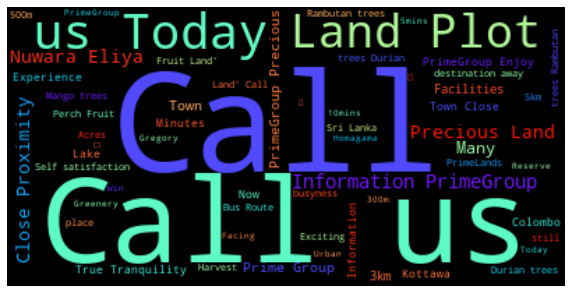

In [22]:
# merge all texts in posts
post_text = ' '.join(df_posts['text'])
post_text = post_text.replace('\n', '') # remove blank lines characters

# update stopwords
stopwords = set(STOPWORDS)
stopwords.update(['https', 'gov', 'au', 'nsw', 's', 're'])

# Generate a word cloud image
wordcloud = WordCloud(random_state=1, 
                      collocations=True, 
                      stopwords=stopwords,
                      max_words=60,
                      background_color='black',
                      colormap ='rainbow',
                      contour_color='steelblue').generate(post_text)

# Function to display word cloud img via matplotlib
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

# plot world cloud    
plot_cloud(wordcloud)